# Test notebook to figure out dynamic time warping in python

Perhaps, I should have though about this before but I didn't do any normalization on the outputs of models. Since that is a scalar, I don't think it will affect dtw but we probably should check.

Do we want to apply a window function to this? 

In [1]:
import os
import keras
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dtw import *
from tqdm import tqdm_notebook as tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def visualize_labels(y, alt=False):
    color = 'cividis' if alt else 'plasma'
    
    idx = np.arange(len(y))

    fig, ax1 = plt.subplots()

    im = ax1.imshow(y[np.newaxis,:], cmap=color, aspect="auto")
    ax1.set_yticks([])
    fig.colorbar(im, ax=ax1)

    plt.tight_layout()
    plt.show()

In [3]:
def visualize_matrix(Y, alt=False):
    color = 'cividis' if alt else 'plasma'
    
    fig, ax1 = plt.subplots()
    
    im = ax1.imshow(Y, cmap=color, interpolation='nearest', aspect="auto")
    fig.colorbar(im, ax=ax1)
    
    plt.tight_layout()
    plt.show()

## Load Pair

In [4]:
model_path = './models/{0}/'.format('task1_sandwich_openface')

task_name = 'task1_sandwich_openface'

path = './data/openface/{0}/'.format(task_name)

#pair = ('0101_sandwich_cut.csv','0102_sandwich_cut.csv')
pair = ('0301_sandwich_cut.csv','0302_sandwich_cut.csv')
#pair = ('0501_sandwich_cut.csv','0502_sandwich_cut.csv')

It seems that the task specific autoencoders overfit more. We get closer to action units on the all_data autoencoders.

As for kmeans it is reversed. It seems we get a better density function from the task specific training?

In [5]:
indicies = ['x_{0}'.format(i) for i in range(0,68)] + ['y_{0}'.format(i) for i in range(0,68)]

df1 = pd.read_csv(os.path.join(path,pair[0]), error_bad_lines=False, warn_bad_lines=True)
face_lmk_1 = df1[indicies]

nans = df1[df1[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    face_lmk_1.drop(dropList, inplace=True)

face_lmk_1.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,934.7,937.6,944.8,954.0,966.3,982.6,1003.7,1029.1,1061.7,1098.1,...,860.6,858.2,848.9,841.3,840.4,839.2,845.0,840.4,841.9,841.5
1,927.9,930.2,936.4,944.6,955.7,971.1,991.8,1016.7,1048.8,1084.8,...,862.4,860.5,852.6,843.9,842.9,841.5,848.1,843.3,844.8,844.3
2,921.6,922.3,927.8,936.3,947.2,962.0,982.9,1007.7,1039.6,1074.1,...,865.5,863.8,856.2,846.9,846.0,844.6,850.7,845.9,847.5,846.9
3,916.1,915.4,921.0,930.7,941.4,955.7,975.4,1000.6,1031.5,1064.7,...,867.5,865.3,857.3,849.8,849.1,847.9,852.2,848.5,850.0,849.6
4,907.9,907.4,913.8,924.3,934.8,949.2,968.8,994.4,1025.2,1057.9,...,869.2,867.3,858.8,851.3,850.6,849.4,853.8,849.5,851.1,850.9


In [6]:
X1 = np.asarray(face_lmk_1.to_numpy()).astype('float32')
print(X1.shape)

(8261, 136)


In [7]:
df2 = pd.read_csv(os.path.join(path,pair[1]), error_bad_lines=False, warn_bad_lines=True)
face_lmk_2 = df2[indicies]

nans = df2[df2[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    face_lmk_2.drop(dropList, inplace=True)

face_lmk_2.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,750.0,744.2,742.9,747.3,752.9,759.0,764.7,770.6,785.4,809.7,...,735.0,730.3,722.8,722.8,724.2,724.4,725.9,725.8,725.1,723.2
1,748.7,742.6,741.8,747.2,752.8,759.1,763.8,769.4,784.4,808.1,...,735.6,730.6,723.3,723.6,725.2,725.7,726.9,727.0,726.0,723.9
2,748.1,742.0,741.0,746.5,752.4,758.9,764.0,769.7,784.6,808.2,...,736.5,731.4,723.9,724.4,726.0,726.5,727.5,728.0,727.0,724.9
3,748.0,742.0,741.2,746.7,752.6,759.2,764.3,770.0,784.9,808.6,...,737.5,732.2,724.7,725.4,727.1,727.6,728.4,728.9,728.0,725.8
4,747.8,741.8,741.2,746.7,752.6,759.3,764.6,770.3,785.1,808.7,...,737.9,732.8,725.4,725.8,727.4,727.9,728.6,729.2,728.4,726.2


In [8]:
X2 = np.asarray(face_lmk_2.to_numpy()).astype('float32')
print(X2.shape)

(8333, 136)


## PCA 32 -> KMeans 5 Model

In [9]:
# scikit-learn v0.24.1
PCA_n_32 = pickle.load(open(model_path + 'pca_n_32.p', 'rb'))
KMeans_5 = pickle.load(open(model_path + 'kmeans_5_from_pca.p', 'rb'))

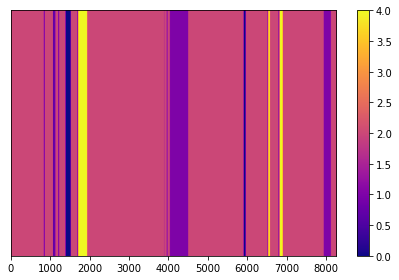

In [10]:
tl1 = KMeans_5.predict(PCA_n_32.transform(X1))
visualize_labels(tl1)

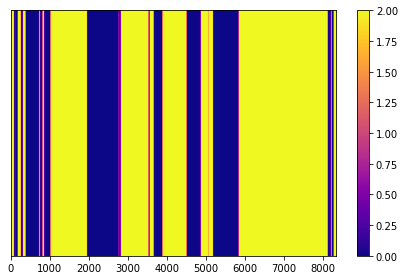

In [11]:
tl2 = KMeans_5.predict(PCA_n_32.transform(X2))
visualize_labels(tl2)

In [12]:
alignment = dtw(tl2, tl1, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

alignment is a DTW (https://dynamictimewarping.github.io/py-api/html/api/dtw.D_T_W_.html#dtw.DTW)

Attributes:

- distance the minimum global distance computed, not normalized.
- normalizedDistance distance computed, normalized for path length, if normalization is known for chosen step pattern.
- N,M query and reference length
- call the function call that created the object
- index1 matched elements: indices in x
- index2 corresponding mapped indices in y
- stepPattern the stepPattern object used for the computation
- jmin last element of reference matched, if open_end=True
- directionMatrix if keep_internals=True, the directions of steps that would be taken at each alignment pair (integers indexing production rules in the chosen step pattern)
- stepsTaken the list of steps taken from the beginning to the end of the alignment (integers indexing chosen step pattern)
- index1s, index2s same as index1/2, excluding intermediate steps for multi-step patterns like [asymmetricP05()]
- costMatrix if keep_internals=True, the cumulative cost matrix
- query, reference if keep_internals=True and passed as the x and y arguments, the query and reference timeseries.

Methods:
- plot(type='alignment', **kwargs) ~ Plottng of dynamic time warp results

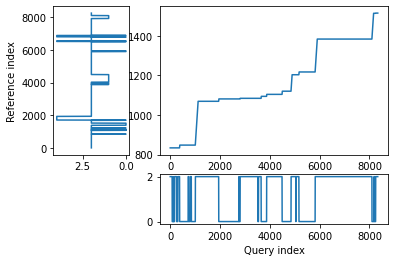

<AxesSubplot:>

In [13]:
alignment.plot('threeway')

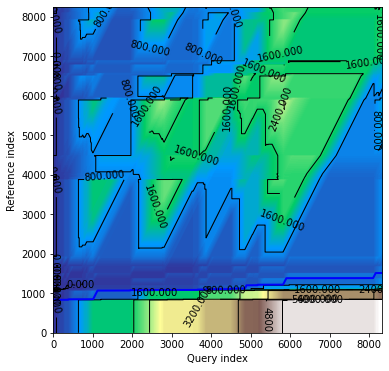

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [14]:
alignment.plot('density')

## Autoencoder 32 -> KMeans 5 Model

In [15]:
Encoder_32 = keras.models.load_model(model_path + 'encoder_32.h5')

# scikit-learn v0.24.1
KMeans_5 = pickle.load(open(model_path + 'kmeans_5_from_auto.p', 'rb'))

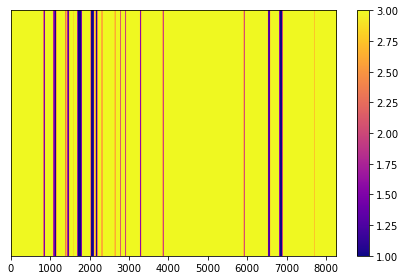

In [16]:
tl1 = KMeans_5.predict(Encoder_32.predict(X1))
visualize_labels(tl1)

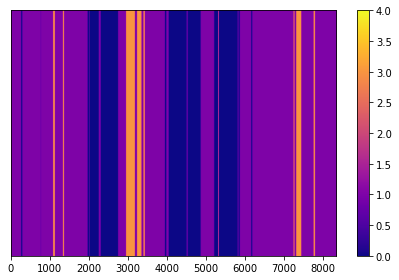

In [17]:
tl2 = KMeans_5.predict(Encoder_32.predict(X2))
visualize_labels(tl2)

In [18]:
alignment = dtw(tl2, tl1, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

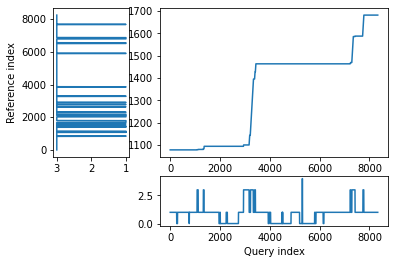

<AxesSubplot:>

In [19]:
alignment.plot('threeway')

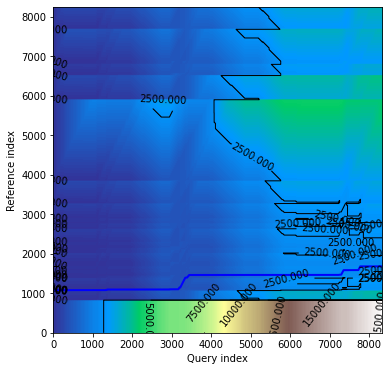

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [20]:
alignment.plot('density')

## PCA 32 Direct Model

In [21]:
# scikit-learn v0.24.1
PCA_n_32 = pickle.load(open(model_path + 'pca_n_32.p', 'rb'))

(8261, 32)


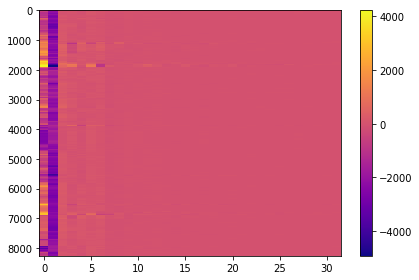

In [22]:
tl1 = PCA_n_32.transform(X1)
print(tl1.shape)
visualize_matrix(tl1)

(8333, 32)


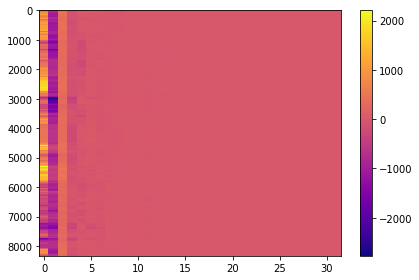

In [23]:
tl2 = PCA_n_32.transform(X2)
print(tl2.shape)
visualize_matrix(tl2)

(8333, 8261)


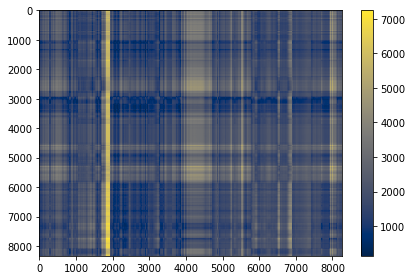

In [24]:
# Following directions from here 
#(https://dynamictimewarping.github.io/py-api/html/api/dtw.dtw.html#dtw.dtw) 
# for multivariate time-series data

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html#scipy.spatial.distance_matrix

from scipy.spatial import distance_matrix 
dmat = distance_matrix(tl2,tl1,p=2)
print(dmat.shape)

visualize_matrix(dmat, True)

In [25]:
alignment = dtw(dmat, dist_method=None, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

In [26]:
# Can we just pass the two time series directly?

alignment = dtw(tl2, tl1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

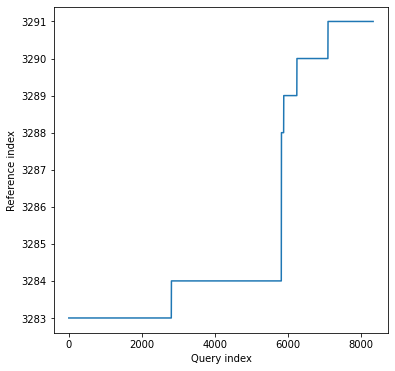

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [27]:
alignment.plot('alignment')

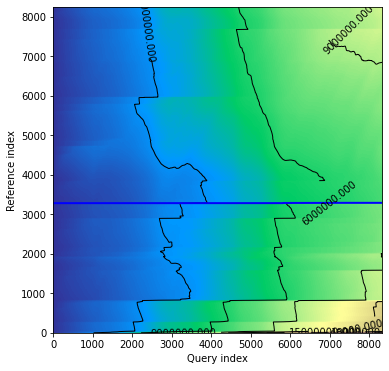

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [28]:
alignment.plot('density')

## Autoencoder 32 Direct Model

In [29]:
Encoder_32 = keras.models.load_model(model_path + 'encoder_32.h5')

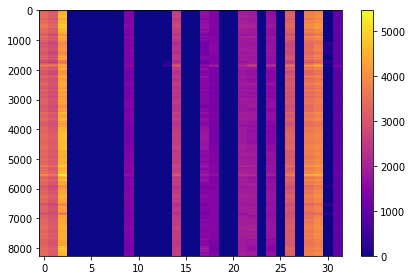

In [30]:
tl1 = Encoder_32.predict(X1)
visualize_matrix(tl1)

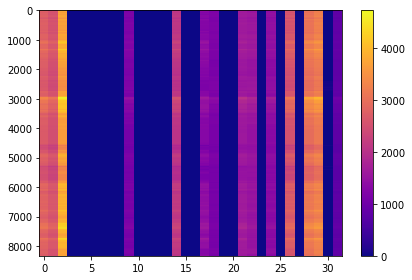

In [31]:
tl2 = Encoder_32.predict(X2)
visualize_matrix(tl2)

(8333, 8261)


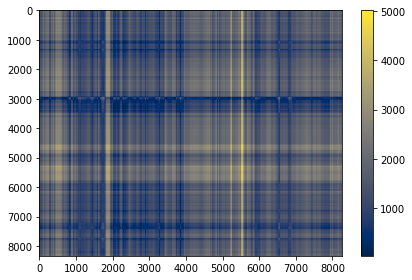

In [32]:
from scipy.spatial import distance_matrix 
dmat = distance_matrix(tl2,tl1,p=2)
print(dmat.shape)

visualize_matrix(dmat, True)

In [33]:
alignment = dtw(tl2, tl1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

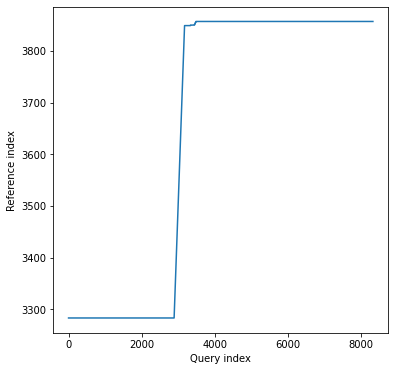

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [34]:
alignment.plot('alignment')

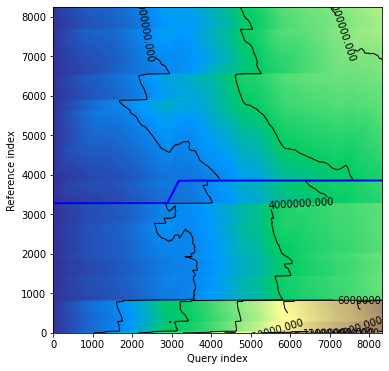

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [35]:
alignment.plot('density')

## PCA 18 Direct Model

In [36]:
# scikit-learn v0.24.1
PCA_n_18 = pickle.load(open(model_path + 'pca_n_18.p', 'rb'))

(8261, 18)


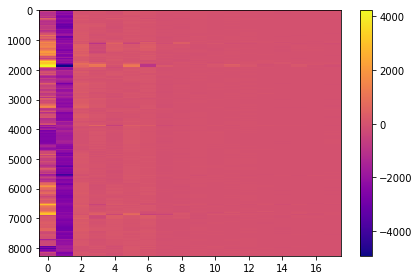

In [37]:
tl1 = PCA_n_18.transform(X1)
print(tl1.shape)
visualize_matrix(tl1)

(8333, 18)


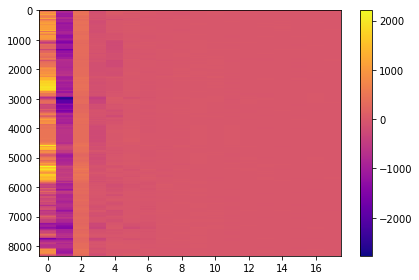

In [38]:
tl2 = PCA_n_18.transform(X2)
print(tl2.shape)
visualize_matrix(tl2)

(8333, 8261)


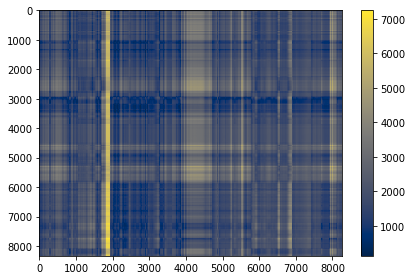

In [39]:
from scipy.spatial import distance_matrix 
dmat = distance_matrix(tl2,tl1,p=2)
print(dmat.shape)

visualize_matrix(dmat, True)

In [40]:
alignment = dtw(tl2, tl1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

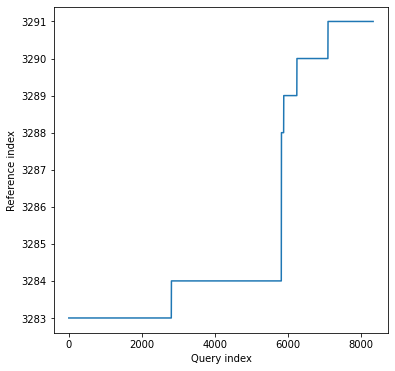

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [41]:
alignment.plot('alignment')

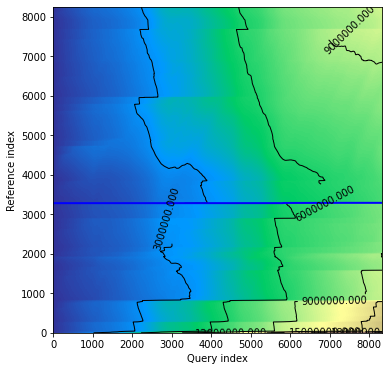

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [42]:
alignment.plot('density')

## Autoencoder 18 Direct

In [43]:
Encoder_18 = keras.models.load_model(model_path + 'encoder_18.h5')

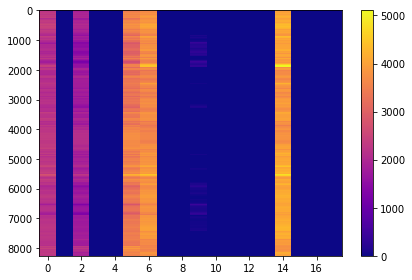

In [44]:
tl1 = Encoder_18.predict(X1)
visualize_matrix(tl1)

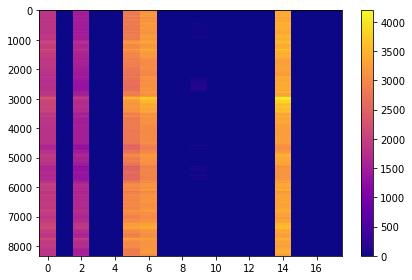

In [45]:
tl2 = Encoder_18.predict(X2)
visualize_matrix(tl2)

(8333, 8261)


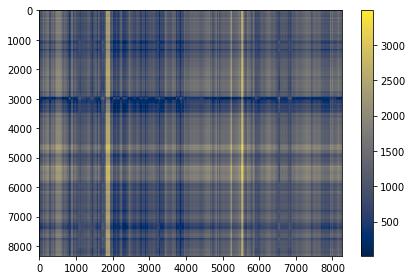

In [46]:
from scipy.spatial import distance_matrix 
dmat = distance_matrix(tl2,tl1,p=2)
print(dmat.shape)

visualize_matrix(dmat, True)

In [47]:
alignment = dtw(tl2, tl1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

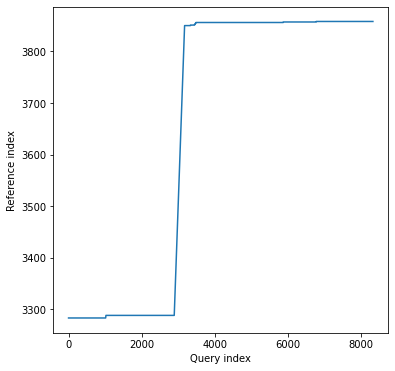

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [48]:
alignment.plot('alignment')

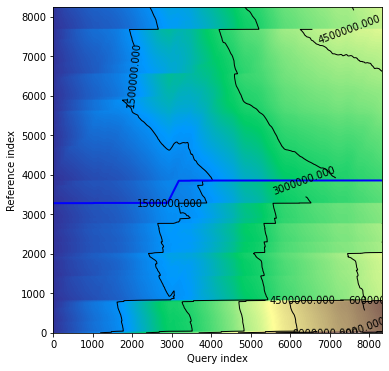

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [49]:
alignment.plot('density')

## Openface action units - Baseline

In [50]:
units = [1,2,4,5,7,9,10,12,14,15,17,20,23,25,26,45]

au_indicies = ['AU{:02}_r'.format(units[i]) for i in range(0, len(units))]

In [51]:
aus1 = df1[au_indicies]

nans = df1[df1[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    aus1.drop(dropList, inplace=True)

print(aus1.shape)
aus1.head()

(8261, 16)


,AU01_r,AU02_r,AU04_r,AU05_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,0.0,0.0,0.84,0.0,1.01,0.51,0.24,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.51,0.0,0.92,0.29,0.35,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.23,0.0,0.75,0.12,0.39,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.62,0.00,0.34,0.06,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.50,0.00,0.44,0.09,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.0


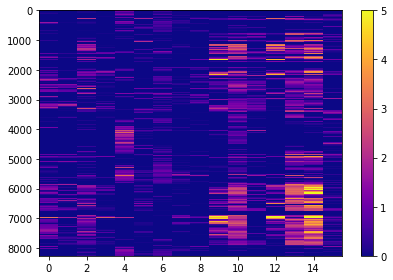

In [52]:
visualize_matrix(aus1)

In [53]:
aus2 = df2[au_indicies]

nans = df2[df2[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    aus2.drop(dropList, inplace=True)

print(aus2.shape)
aus2.head()

(8333, 16)


,AU01_r,AU02_r,AU04_r,AU05_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,0.00,0.0,0.82,0.0,0.0,0.0,0.82,0.00,0.0,0.46,1.65,0.12,0.07,0.85,1.14,0.00
1,0.45,0.0,0.91,0.0,0.0,0.0,0.97,0.03,0.0,0.60,1.80,0.04,0.02,0.80,1.47,0.04
2,0.62,0.0,0.96,0.0,0.0,0.0,1.06,0.07,0.0,0.69,1.79,0.08,0.00,0.64,1.65,0.04
3,0.54,0.0,1.01,0.0,0.0,0.0,1.17,0.10,0.0,0.76,1.73,0.15,0.00,0.48,1.61,0.00
4,0.51,0.0,0.99,0.0,0.0,0.0,1.24,0.08,0.0,0.87,1.62,0.22,0.00,0.37,1.56,0.00


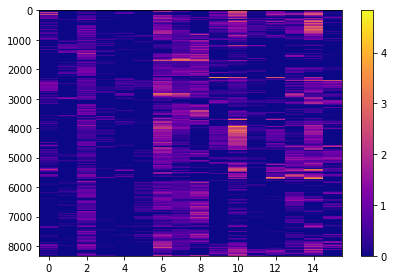

In [54]:
visualize_matrix(aus2)

(8333, 8261)


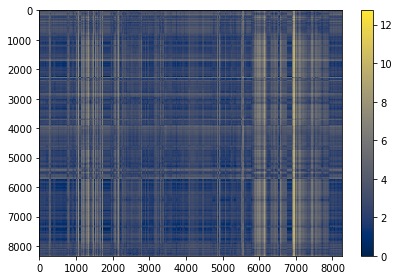

In [55]:
from scipy.spatial import distance_matrix 
dmat = distance_matrix(aus2,aus1,p=2)
print(dmat.shape)

visualize_matrix(dmat, True)

In [56]:
alignment = dtw(aus2, aus1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

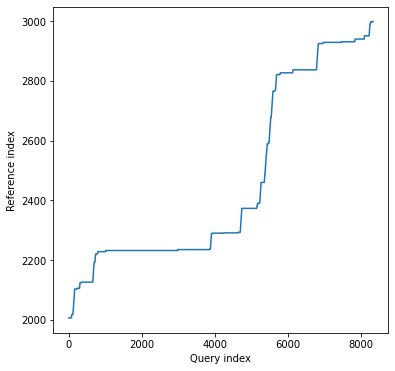

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [57]:
alignment.plot('alignment')

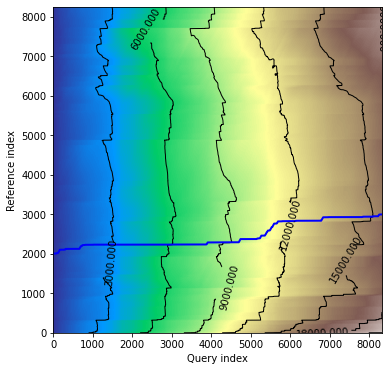

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [58]:
alignment.plot('density')

Sanity Check

In [59]:
alignment = dtw(aus1, aus1, keep_internals=True, 
                open_begin=True, open_end=True, 
                step_pattern='asymmetric')

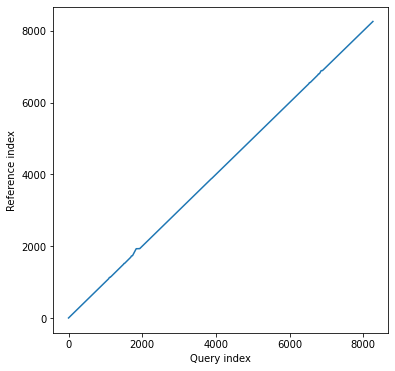

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [60]:
alignment.plot('alignment')

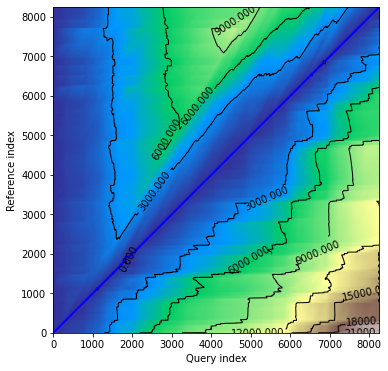

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [61]:
alignment.plot('density')